# Final Assignment Computational Macroeconomics

### Paula Beck
04.03.2022

In [105]:
# import all necessary packages

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm

# set seed for random numbers
np.random.seed(123)

# #1 Define matrices
$ A z_t = B$ ; $z_t = [g_t, y_t, \pi_t, i_t]'$

$ A = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    - \bar{g} & 1 & 0 & (1-\bar{g}) \sigma^{-1} \\
    \kappa \sigma \frac{\bar{g}}{1-\bar{g}} & -\kappa(\frac{\sigma}{1-\bar{g}} + \eta) & 1 & 0 \\
    0 & -\phi_y & - \phi_{\pi} & 1 
  \end{bmatrix} $

$ B = \begin{bmatrix}
      \rho_g g_{t-1} + \epsilon_t^9\\
      E_t y_{t+1} + (1-\bar{g}) \sigma^{-1} E_t \pi_{t+1} - \bar{g} E_t g_{t+1} \\
      \beta E_t \pi_{t+1} \\
      0\\
      \end{bmatrix}$


In [106]:
# setup parameters in a dictionary
params = {'sigma': 1, 'eta':2, 'kappa': 0.3, 'beta': 0.995, 'phi_pi':1.5, 'phi_y':0.1, 'rho_g':0.7, 'gbar':0.25}

# define matrix A
a31 = params['kappa']*params['sigma']*params['gbar']/(1-params['gbar'])
a32 = -params['kappa']*(params['sigma']/(1-params['gbar']) + params['eta'])
A = np.array([[1,0,0,0],
                [-params['gbar'],1,0, (1-params['gbar'])*params['sigma']**(-1)],
                [a31,a32,1,0],
                [0,-params['phi_y'],-params['phi_pi'],1]])
A

array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [-0.25,  1.  ,  0.  ,  0.75],
       [ 0.1 , -1.  ,  1.  ,  0.  ],
       [ 0.  , -0.1 , -1.5 ,  1.  ]])

# #2 Define function

In [107]:
# define function 
def NKM(input, A = A, params=params):
    # input: 8 elements
    cg = input[0:4] # unpack first 4 elements und define them as cg
    ce = input[4:8] # unpack next 4 elements und define them as ce

    gt_1 = 0 # 0 as in steady state
    eg, ey, epi, ei = cg * gt_1 + ce * 0 # unpack expectations based on equation 6, shock is zero in steady state

    # define B for gt_1 = 1 and calculate the implied values
    B1 = np.array([[params['rho_g']],
                    [ey + (1-params['gbar'])*params['sigma']**(-1) * epi - params['gbar']*eg],
                    [params['beta']* epi],
                    [0]])
    implied1 = np.linalg.inv(A) @ B1

    # define B for epsilon t_1 = 1 and calculate the implied values
    B2 = B1.copy() # same as before
    B2[0] = 1 # change first element
    implied2 = np.linalg.inv(A) @ B2
    
    # but implied values for cg and ce in one vector
    implied = np.append(implied1,implied2)

    # calculate the difference between the input values and the implied values by the model
    dif = input - implied
    # function returns this difference
    return dif

# #3 MSV solution

In [108]:
# make a random guess about the 8 values of the model
guess = np.random.randn(8)

# use fsolve to calculate the minimum state variable solution 
msv = fsolve(NKM, guess) #  first input is the function, second is the guess where fsolve should start
msv # first 4 elements are the values for Cg, the next 4 element correspond to Ce

array([0.7       , 0.11534091, 0.04534091, 0.07954545, 1.        ,
       0.16477273, 0.06477273, 0.11363636])

# #4 Calculate impulse responses

In [109]:
N = 30 # number of periods
epsg = 0.01 # shock to g

# unpack and reshape msv solution into vectors, Cg and Ce 
cg = msv[0:4].reshape(4,1)
ce = msv[4:8].reshape(4,1)
 
# start a list in which to save zt
# first entry is Ce times error
z = [ce * epsg ]

# loop through N periods
for i in range(N):
    zt = cg * z[-1][0] # new zt is Cg * gt-1
    # z[-1] is last element from list (period t-1), [0] picks the first element from array -> gt-1
    z.append(zt) # append new zt to list

# unpack elements of zt using list comprehensions
gov_spending = [x[0][0] for x in z]
output = [x[1][0] for x in z]
inflation = [x[2][0] for x in z]
interest = [x[3][0] for x in z]

# #5 Plot impulse responses

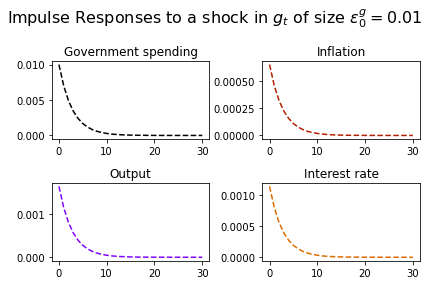

In [110]:
fig, ax = plt.subplots(2,2) # define figure and axis, including the number of rows and columns for the subfigures
cmap = cm.get_cmap('gnuplot') # choose a colormap
# for each axis, define the variable, all in dashed lines, and choose a color from the colormap
ax[0,0].plot(gov_spending, linestyle = 'dashed', color=cmap(0))
ax[0,0].set_title('Government spending') # set title for each subfigure
ax[1,0].plot(output, linestyle = 'dashed', color=cmap(0.25) )
ax[1,0].set_title('Output')
ax[0,1].plot(inflation, linestyle = 'dashed', color=cmap(0.5) )
ax[0,1].set_title('Inflation')
ax[1,1].plot(interest, linestyle = 'dashed', color=cmap(0.75) )
ax[1,1].set_title('Interest rate')
fig.suptitle(r'Impulse Responses to a shock in $g_t$ of size $\epsilon_0^g = 0.01$', fontsize=16) # title of figure
fig.tight_layout() # makes sure the labels from the figures do not overlap
plt.show() # show the figure

# #6 Interpretation

economic intuition for response of each variable

# #7 Linear Time Iteration: Function

In [111]:
# define a function using the matrices A, M and D as input as well es a first guees an F
def lin_time_iter(A, M, D, Fguess):
    # make a while loop as before until the difference between F and Fnew is small enough
    F = Fguess
    Fnew = np.linalg.inv(A - M @ F) @ D
    while np.max(abs(F - Fnew)) > 1e-6:
        F = Fnew
        Fnew = np.linalg.inv(A - M @ F) @ D
    # save the latest F when the loop stops
    F_final = Fnew
    # Calculate Q
    Q = np.linalg.inv(A - M @ F_final)
    # function return the solution for F and Q
    return F_final, Q

# #8 Define Matrices A, M and D

$ A z_t = M E z_{t+1} + D z_{t-1} + u_t$

In [112]:
A = A # same as before

M = np.array([np.zeros(4),
            [-params['gbar'],1, (1-params['gbar'])*params['sigma']**(-1),0],
            [0,0,params['beta'],0],
            np.zeros(4)])

D = np.zeros((4,4))
D[0,0] = params['rho_g']

# guess a 4x4 matrix
F_init = np.random.randn(4,4)

# call the function and save results F and Q
F,Q = lin_time_iter(A=A, M=M, D=D, Fguess=F_init)

In [113]:
# to be deleted
z = [Q * epsg]
e = [epsg]

for i in range(N):
    et = params['rho_g'] * e[-1]
    zt = F @ np.array([[et],[0],[0],[0]], dtype=float)
    e.append(et)
    z.append(zt)

error = [x[0][0] for x in z]
output = [x[1][0] for x in z]
inflation = [x[2][0] for x in z]
interest = [x[3][0] for x in z]

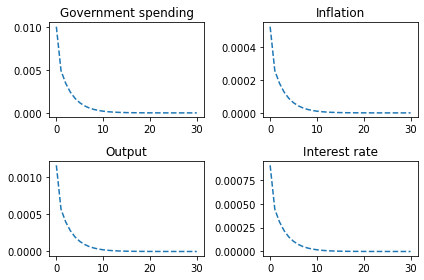

In [114]:
# to be deleted
gov_spending = error
fig, ax = plt.subplots(2,2)

ax[0,0].plot(gov_spending, linestyle = 'dashed')
ax[0,0].set_title('Government spending')
ax[1,0].plot(output, linestyle = 'dashed' )
ax[1,0].set_title('Output')
ax[0,1].plot(inflation, linestyle = 'dashed' )
ax[0,1].set_title('Inflation')
ax[1,1].plot(interest, linestyle = 'dashed' )
ax[1,1].set_title('Interest rate')
fig.tight_layout()
plt.show()

In [115]:
print(F)
print(Q)

[[0.7        0.         0.         0.        ]
 [0.08116078 0.         0.         0.        ]
 [0.03677505 0.         0.         0.        ]
 [0.06327865 0.         0.         0.        ]]
[[ 1.          0.          0.          0.        ]
 [ 0.11594409  0.45454545 -0.51136364 -0.34090909]
 [ 0.05253526  0.45454545  0.48863636 -0.34090909]
 [ 0.0903973   0.72727273  0.68181818  0.45454545]]


In [116]:
print(cg)
print(ce)

[[0.7       ]
 [0.11534091]
 [0.04534091]
 [0.07954545]]
[[1.        ]
 [0.16477273]
 [0.06477273]
 [0.11363636]]


In [117]:
print(F[:,0]) # should be equal to cg
print(Q[:,0]) # should be equal to ce

[0.7        0.08116078 0.03677505 0.06327865]
[1.         0.11594409 0.05253526 0.0903973 ]


# #9 Interpretation

first columns of F,Q have same ratios

first column of F: how zt reacts to gt-1